# Implementing LSM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float, dim: int, n: int, seed: int, use_AV: bool = False):
        """ Class for pricing American Options using LSM. 
        
        Parameters: 
        r (float): Risk-free interest rate
        S0 (float): Initial asset value
        K (float): Strike price
        T (float): Time to maturity, in years
        σ (float): Volatility coefficient for diffusion
        dim (int): Number of paths to simulate
        n (int): Number of time steps between time 0 and time T
        seed (int): Random seed for reproducibility
        use_AV (bool): Flag to use Antithetic Variates method (default: False)
        """
        
        assert σ >= 0, 'Volatility cannot be less than zero'
        assert S0 >= 0, 'Initial stock price cannot be less than zero'
        assert T >= 0, 'Time to maturity cannot be less than zero'
        assert n >= 0, 'Number of slices per year cannot be less than zero'
        assert dim >= 0, 'Number of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r * self.Δ)
        self.use_AV = use_AV
        self.dim = dim

        if use_AV:
            assert dim % 2 == 0, 'For AV, the number of paths (dim) must be even'
            half_dim = dim // 2
            Z_half = np.random.normal(0, 1, (half_dim, self.n - 1)) #Z_half matrix with dimension (half_dim, self.n-1), representing random increments of the asset´s price over time for half the paths'
            self.Z = np.concatenate((Z_half, -Z_half), axis=0)  # Antithetic variates. Creating full matrix self:Z by concatenating Z_half with its negation -Z.half.
        else:
            self.Z = np.random.normal(0, 1, (dim, self.n - 1))  # Original method

        self.S = np.full((dim, self.n), np.nan)  # Allocate space for stock price process

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for j in range(1,n):
            S[:,j] = S[:,j-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,j-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        BM = (r - 0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:,:] = np.log(S0)
        S[:,1:] += np.cumsum(BM, axis=1)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        
        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes
        
        for j in range(1,n):
            # Compute jump sizes for each path
            M = α*N[:,j-1] + β*np.sqrt(N[:,j-1])*Z_2[:,j-1]
            # if no jump set jump process to zero 
            M = np.where(N[:,j-1] > 0, M, 0)
            # Calculate the combined diffusion and jump process
            S[:,j] = S[:,j-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,j-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2
        
        # if no jump set M = 0
        M = np.where(N > 0, M, 0)
        
        # Calculate the combined diffusion and jump process for all time steps
        S[:,:] = np.log(S0)
        S[:,1:] = np.log(S0) + np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)

        self.S = np.exp(S)

        return self.S

    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for j in range(1,n):
            S[:,j] = S[:,j-1] + r*S[:,j-1]*Δ + σ*S[:,j-1]**(γ/2)*np.sqrt(Δ)*Z[:,j-1]
        self.S = S

        return self.S
    
    def BS_option_value(self, S, K, r, σ, T, otype='put'):
        ''' Closed-form valuation of a European option in Black-Scholes.

        Parameters:
        S (float): Current asset price
        K (float): Strike price
        r (float): Risk-free interest rate
        σ (float): Volatility coefficient for diffusion
        T (float): Time to maturity, in years
        otype (str): Option type either call or put (defualt: put)

        Returns:
        float: Option price of a European put option
        '''

        d1 = (np.log(S/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))
        d2 = d1 - σ*np.sqrt(T)

        if otype == 'call':
            value = (S * stats.norm.cdf(d1, 0., 1.) -
                 K * np.exp(-r * T)*stats.norm.cdf(d2, 0., 1.))
        elif otype == 'put':
            value = K * np.exp(-r*T)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)
        else: 
            raise ValueError('Invalid option type.')

        return value
    
    def american_option_LSM(self, poly_degree: int, otype: str = 'put'):
        """
        American option pricing using the LSM as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): x^n, number of basis functions
        otype (str): call or put (default)
        
        Returns:
        float: V0, LSM Estimator
        np.ndarray: Exercise times for each path (in case of early exercise)
        """
        
        assert otype == 'call' or otype == 'put', 'Invalid option type.'
        assert len(self.S) != 0, 'Please simulate a stock price process.'
        
        # unpack
        S = self.S
        K = self.K
        S0 = self.S0
        n = self.n
        dim = self.dim
        df = self.df
        
        # Initialize exercise_times array to store exercise times for each path
        exercise_times = np.full(dim, self.T)  # Initialize with T (no exercise)
        
        # Initialize an array to store payoffs
        payoffs = np.zeros(dim)

        # inner values
        if otype == 'call':
            self.intrinsic_val = np.maximum(S - K, 0)
        elif otype == 'put':
            self.intrinsic_val = np.maximum(K - S, 0)
            
        # last day cashflow == last day intrinsic value
        V = np.copy(self.intrinsic_val[:,-1])

        # Backward Induction
        for i in range(n - 2, 0, -1): # start at second to last and end at second to first
            # a. find itm path 
            # (potentially) better estimate the continuation value
            itm_path = np.where(self.intrinsic_val[:,i] > 0)  # evaluate: S[:,i] vs. K
            V = V * df # discount next period value
            V_itm = V[itm_path[0]] # define subset (note, we need to set [0] due to np.where being tuple)
            S_itm = S[itm_path[0],i]
            
            # b. run regression and calculate conditional expectation (LSM)
            # initialize continuation value
            C = np.zeros(shape=dim)
            # if only 5 itm paths (probably, otm options), then continuation value is zero
            if len(itm_path[0]) > 5:
                rg = np.polyfit(S_itm, V_itm, poly_degree)  # polynomial regression
                C[itm_path[0]] = np.polyval(rg, S_itm)  # evaluate conditional expectation
            
            # c. Calculation of value function at i 
            # if hold: V = 0, if exercise: V = intrinsic value
            exercise_condition = self.intrinsic_val[:, i] > C
            V = np.where(exercise_condition, self.intrinsic_val[:, i], V)
            
            for idx in np.where(exercise_condition)[0]:
                payoffs[idx] = self.intrinsic_val[idx, i]
                exercise_times[idx] = i * self.Δ
            
            # Update exercise times for paths that exercised
            exercise_times[exercise_condition] = i * self.Δ
            
        self.V0 = df * np.average(V)
        
        return self.V0, exercise_times
    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, self.S.T, lw=1, alpha=0.25)

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Stock Price Simulation Paths')
        plt.legend()
        
        plt.show()
        
    
        


In [59]:
# Initialize the Monte Carlo option pricing with a specific seed
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=10000, n=50, seed=15001, use_AV=True)
# Generate 'dim' no. of stock price process paths
#simulated_paths = mc_option_pricing.GeometricBrownianMotion()
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

#simulated_paths = mc_option_pricing.MertonJumpDiffusion(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.MertonJumpDiffusion_vec(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.CEV(γ=1.5)

# plot stock price process
#mc_option_pricing.plot_paths() 

In [60]:
mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')

(4.476026081009416, array([0.04, 1.  , 1.  , ..., 0.04, 1.  , 0.06]))

In [61]:
# Calculate the European put option price at expiration date T
european_put_T = mc_option_pricing.BS_option_value(S=S, K=mc_option_pricing.K, r=mc_option_pricing.r, σ=sigma, T=T)
print(european_put_T)



1.2823122758344252


## Producing *American put prices* similar to *Simulated American* in table 1 in Longstaff.
- Where the simulation is based on 100000 (50000 plus 50000 antithetic) paths for the stock price.

In [9]:
def price_options_for_various_parameters():
    # Parameters
    r = 0.06  # risk-free rate
    K = 40.   # strike price
    dim = 100000  # number of simulation paths
    n = 50  # number of exercise rights per year
    seed = 15001  # random seed for reproducibility
    use_AV = True  # antithetic variates
    poly_degree = 3  # polynomial degree for LSM regression

    # Different characteristics
    S_values = [36, 38, 40, 42, 44]
    sigma_values = [0.20, 0.40]
    T_values = [1, 2]

    # Store results
    results = []

    # Iterate over each combination of S, sigma, and T
    for S in S_values:
        for sigma in sigma_values:
            for T in T_values:
                # Initialize the Monte Carlo pricer
                mc_option_pricing = MonteCarloOptionPricing(r, S, K, T, sigma, dim, n, seed, use_AV)
                # Simulate the asset paths
                mc_option_pricing.GeometricBrownianMotion_vec()
                # Price the option using LSM
                option_price = mc_option_pricing.american_option_LSM(poly_degree, otype='put')
                # Store the results
                results.append((S, sigma, T, option_price))
                # Print individual values without formatting the entire tuple
                print(f"S: {S}, Sigma: {sigma}, T: {T}, American Put Option Price: {option_price[0]:.4f}")

    return results

# Call the function to price the options
option_prices = price_options_for_various_parameters()


S: 36, Sigma: 0.2, T: 1, American Put Option Price: 4.4720
S: 36, Sigma: 0.2, T: 2, American Put Option Price: 4.8259
S: 36, Sigma: 0.4, T: 1, American Put Option Price: 7.0751
S: 36, Sigma: 0.4, T: 2, American Put Option Price: 8.4595
S: 38, Sigma: 0.2, T: 1, American Put Option Price: 3.2400
S: 38, Sigma: 0.2, T: 2, American Put Option Price: 3.7267
S: 38, Sigma: 0.4, T: 1, American Put Option Price: 6.1222
S: 38, Sigma: 0.4, T: 2, American Put Option Price: 7.6295
S: 40, Sigma: 0.2, T: 1, American Put Option Price: 2.3049
S: 40, Sigma: 0.2, T: 2, American Put Option Price: 2.8727
S: 40, Sigma: 0.4, T: 1, American Put Option Price: 5.2752
S: 40, Sigma: 0.4, T: 2, American Put Option Price: 6.8784
S: 42, Sigma: 0.2, T: 1, American Put Option Price: 1.6036
S: 42, Sigma: 0.2, T: 2, American Put Option Price: 2.1992
S: 42, Sigma: 0.4, T: 1, American Put Option Price: 4.5470
S: 42, Sigma: 0.4, T: 2, American Put Option Price: 6.1980
S: 44, Sigma: 0.2, T: 1, American Put Option Price: 1.09

## Correlations

C:\Users\user\AppData\Local\Temp\ipykernel_8252\1295093597.py:249: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))


Processed: 96/2/0.4
Processed: 96/3/0.4
Processed: 96/4/0.4
Processed: 98/2/0.4
Processed: 98/3/0.4
Processed: 98/4/0.4
Processed: 100/2/0.4
Processed: 100/3/0.4
Processed: 100/4/0.4
Processed: 102/2/0.4
Processed: 102/3/0.4
Processed: 102/4/0.4
Processed: 104/2/0.4
Processed: 104/3/0.4
Processed: 104/4/0.4


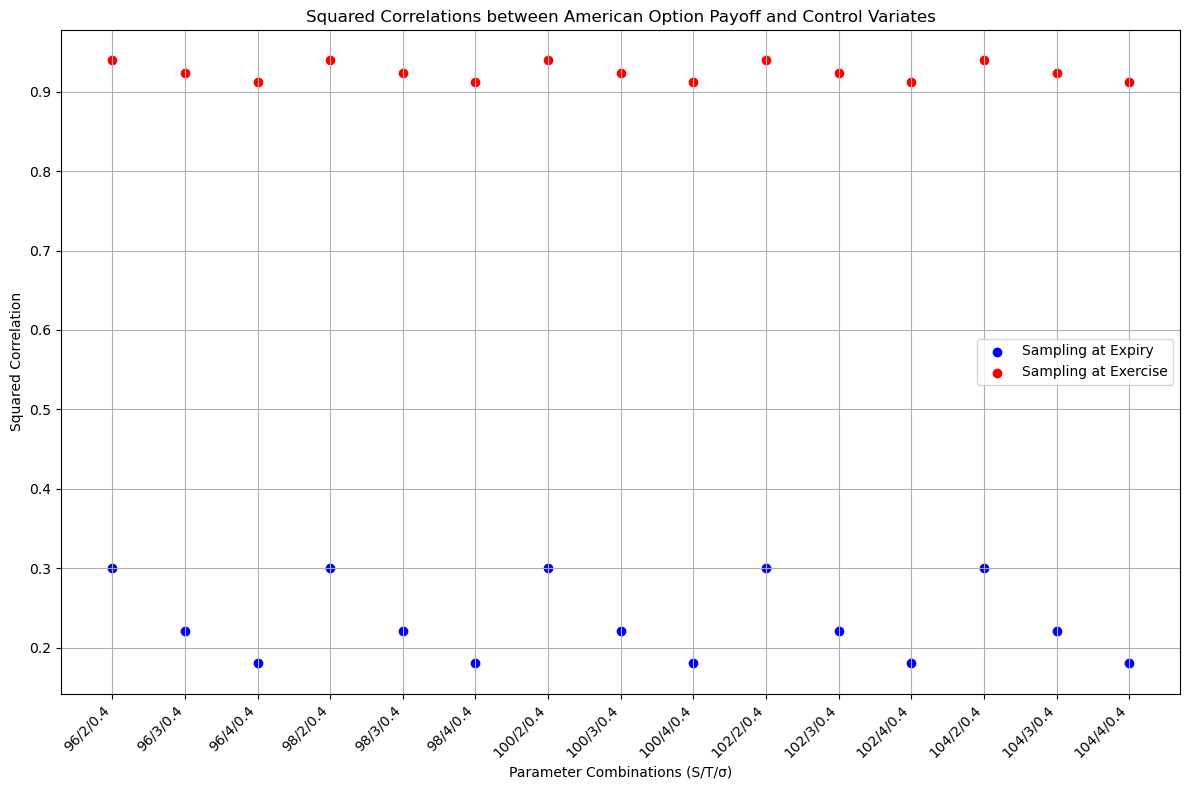

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define a range of parameter values (e.g., different values of S, sigma, and T)
S_values = [96, 98, 100, 102, 104]
sigma_values = [0.40]
T_values = [2,3,4]

# Initialize empty arrays to store squared correlations and labels
squared_correlations_T = []
squared_correlations_tau = []
parameter_labels = []

# Initialize Monte Carlo option pricing object with default parameters
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=100., K=40., T=1., σ=0.2, dim=100000, n=50, seed=15001, use_AV=True)

# Correct parameter updates
for S in S_values:
    for σ in sigma_values:
        for T in T_values:
            # Update parameters correctly
            mc_option_pricing.S0 = S0 # Update initial stock price
            mc_option_pricing.σ = σ   # Update volatility
            mc_option_pricing.T = T   # Update time to maturity
            
            # Simulate the asset paths
            mc_option_pricing.GeometricBrownianMotion_vec()
            
            # Calculate the American option payoff at expiration date T
            american_payoff_T = np.maximum(mc_option_pricing.K - mc_option_pricing.S[:,-1], 0)
            
            # Calculate the European put option price at expiration date T
            european_put_T = mc_option_pricing.BS_option_value(otype='put', S=mc_option_pricing.S[:,-1], K=mc_option_pricing.K, r=mc_option_pricing.r, σ=sigma, T=T)
            
            # Calculate the European put option price at exercise time tau (using mc_option_pricing.T - exercise_times)
            _, exercise_times = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')
            european_put_tau = mc_option_pricing.BS_option_value(otype='put', S=mc_option_pricing.S[:,-1], K=mc_option_pricing.K, r=mc_option_pricing.r, σ=sigma, T=T-exercise_times)
            
            # Calculate the squared correlations between American payoff and control variates
            squared_correlation_T, _ = pearsonr(american_payoff_T, european_put_T)
            squared_correlation_tau, _ = pearsonr(american_payoff_T, european_put_tau)
            
            # Append squared correlations to the respective arrays
            squared_correlations_T.append(squared_correlation_T**2)
            squared_correlations_tau.append(squared_correlation_tau**2)
            
            # Create a label in the format "S/T/σ"
            label = f"{S}/{T}/{sigma}"
            parameter_labels.append(label)
            
            # Debugging: Print parameter combinations
            print(f"Processed: {label}")

# Create an array of x-values (from 0 to the number of parameter combinations)
x_values = range(len(parameter_labels))

# Create a white background for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('white')

# Plot the squared correlations as scatter points with parameter labels on the x-axis
ax.scatter(x_values, squared_correlations_T, label='Sampling at Expiry', marker='o', color='b')
ax.scatter(x_values, squared_correlations_tau, label='Sampling at Exercise', marker='o', color='r')
ax.set_xlabel("Parameter Combinations (S/T/σ)")
ax.set_ylabel("Squared Correlation")
ax.set_title("Squared Correlations between American Option Payoff and Control Variates")
ax.set_xticks(x_values)
ax.set_xticklabels(parameter_labels, rotation=45, ha='right')
ax.legend()
ax.grid(True)

# Adjust the spacing and display the plot
plt.tight_layout()

# Save the figure in the current folder
plt.savefig('correlation_plot_control_variates.png')

# Show the plot (optional)
plt.show()

Gennemforsøg


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define a range of parameter values (e.g., different values of S, sigma, and T)
S_values = [96, 98, 100, 102, 104]
sigma_values = [0.40]
T_values = [2,3,4]

# Initialize empty arrays to store squared correlations and labels
squared_correlations_T = []
squared_correlations_tau = []
parameter_labels = []

# Initialize Monte Carlo option pricing object with default parameters
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=100., K=40., T=1., σ=0.2, dim=100000, n=50, seed=15001, use_AV=True)

for S0 in S_values:
    for σ in sigma_values:
        for T in T_values:
            # Update parameters correctly
            mc_option_pricing.S0 = S0
            mc_option_pricing.σ = σ
            mc_option_pricing.T = T
            
            # Simulate the asset paths
            mc_option_pricing.GeometricBrownianMotion_vec()
            
            # Calculate the actual American option payoff using the LSM method
            average_payoff, payoffs, exercise_times = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')
            
            # Calculate the European put option price at expiration date T
            european_put_T = [mc_option_pricing.BS_option_value(otype='put', S=S, K=mc_option_pricing.K, r=mc_option_pricing.r, σ=σ, T=T) for S in mc_option_pricing.S[:,-1]]
            
            # Calculate the European put option price at exercise time tau
            S_at_tau = mc_option_pricing.S[np.arange(mc_option_pricing.dim), np.minimum(np.floor(exercise_times/mc_option_pricing.Δ).astype(int), mc_option_pricing.n - 1)]
            european_put_tau = [mc_option_pricing.BS_option_value(otype='put', S=S_tau, K=mc_option_pricing.K, r=mc_option_pricing.r, σ=σ, T=max(0, T - tau)) for S_tau, tau in zip(S_at_tau, exercise_times)]
            
            # Calculate the squared correlations between American payoffs and European option prices
            squared_correlation_T, _ = pearsonr(american_payoffs, european_put_T)
            squared_correlation_tau, _ = pearsonr(american_payoffs, european_put_tau)
            
            # Append squared correlations to the respective arrays
            squared_correlations_T.append(squared_correlation_T**2)
            squared_correlations_tau.append(squared_correlation_tau**2)
            
            # Create a label in the format "S0/T/σ"
            label = f"{S0}/{T}/{σ}"
            parameter_labels.append(label)
            # Debugging prints
            print(f"Processed Parameters: S0={S0}, σ={σ}, T={T}")
            print(f"American Payoff at T: {american_payoffs[:5]}")  # Show first 5 values for brevity
            print(f"European Put at T: {european_put_T[:5]}")
            print(f"European Put at Optimal Tau: {european_put_tau[:5]}")
            print(f"Exercise Times: {exercise_times[:5]}")

# Create an array of x-values (from 0 to the number of parameter combinations)
x_values = range(len(parameter_labels))

# Create a white background for the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('white')

# Plot the squared correlations as scatter points with parameter labels on the x-axis
ax.scatter(x_values, squared_correlations_T, label='Sampling at Expiry', marker='o', color='b')
ax.scatter(x_values, squared_correlations_tau, label='Sampling at Exercise', marker='o', color='r')
ax.set_xlabel("Parameter Combinations (S/T/σ)")
ax.set_ylabel("Squared Correlation")
ax.set_title("Squared Correlations between American Option Payoff and Control Variates")
ax.set_xticks(x_values)
ax.set_xticklabels(parameter_labels, rotation=45, ha='right')
ax.legend()
ax.grid(True)

# Adjust the spacing and display the plot
plt.tight_layout()

# Save the figure in the current folder
plt.savefig('correlation_plot_control_variates.png')

# Show the plot (optional)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8252\2322314867.py:249: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))


Processed Parameters: S0=96, σ=0.4, T=2
American Payoff at T: [0. 0. 0. 0. 0.]
European Put at T: [0.4595475494823855, 0.10002758453633576, 0.04108907800473305, 2.480840719047988, 0.3571425376078077]
European Put at Optimal Tau: [0.0, 0.0, 0.0, 0.0, 0.0]
Exercise Times: [2 2 2 2 2]
Processed Parameters: S0=96, σ=0.4, T=3
American Payoff at T: [0. 0. 0. 0. 0.]
European Put at T: [0.9736487511433505, 0.3266673375633655, 0.17418078048763086, 3.3785048389670393, 0.8115038195190447]
European Put at Optimal Tau: [0.0, 0.0, 0.0, 0.0, 0.0]
Exercise Times: [3 3 3 3 3]
Processed Parameters: S0=96, σ=0.4, T=4
American Payoff at T: [0. 0. 0. 0. 0.]
European Put at T: [1.4598127466855093, 0.613841731420131, 0.3744611619376703, 3.9948694548875494, 1.2623045055087272]
European Put at Optimal Tau: [0.0, 0.0, 0.0, 0.0, 0.0]
Exercise Times: [4 4 4 4 4]
Processed Parameters: S0=98, σ=0.4, T=2
American Payoff at T: [0. 0. 0. 0. 0.]
European Put at T: [0.4232742858904994, 0.09044853778478174, 0.03679704033

KeyboardInterrupt: 

# Pricing an Option Surface

In [63]:
def price_american_options():
    r = 0.03  # risk-free rate
    S0 = 100  # current stock price
    σ = 0.25  # volatility
    dim = 1_000  # number of simulation paths
    n = 504  # number of exercise rights per year
    seed = 42  # random seed for reproducibility
    poly_degree = 3  # polynomial degree for LSM regression
    # Define maturities and strikes
    maturities = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 15/12, 18/12, 2, 30/12, 3, 4])
    strikes = np.arange(0.8 * S0, 1.21 * S0, 0.05 * S0)
    # Iterate over each maturity and strike combination
    for T in maturities:
        for K in strikes:
            # Initialize the Monte Carlo pricer
            mcpricer = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)
            # Simulate the asset paths
            mcpricer.GeometricBrownianMotion_vec()
            # Price the option using LSM
            option_price = mcpricer.american_option_LSM(poly_degree, otype='put')  
            # Output the results
            print(f"Maturity: {T:.2f} years, Strike: {K:.2f}, American Put Option Price: {option_price:.2f}")

# Call the function to price the options
price_american_options()

TypeError: unsupported format string passed to tuple.__format__

In [ ]:
t0 = time()
optionValues = price_american_options()  # calculate all values
t1 = time(); d1 = t1 - t0
print("Duration in Seconds %6.3f" % d1)

# Herunder implementeres Implicit Finite Difference á la: https://www.researchgate.net/publication/30758355_Numerical_methods_for_the_valuation_of_financial_derivatives

In [62]:
# Source:  https://www.researchgate.net/publication/30758355_Numerical_methods_for_the_valuation_of_financial_derivatives
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import pandas as pd

def Amerput_implicit(S, K, r, sigma, T, N, M):
    dt = T / N
    ds = 2 * S / M
    A = scipy.sparse.lil_matrix((M+1, M+1))
    f = np.maximum(K - np.arange(0, M+1) * ds, 0)

    for m in range(1, M):
        x = 1 / (1 - r * dt)
        A[m, m-1] = x * (r * m * dt - sigma**2 * m**2 * dt) / 2
        A[m, m] = x * (1 + sigma**2 * m**2 * dt)
        A[m, m+1] = x * (-r * m * dt - sigma**2 * m**2 * dt) / 2

    A[0, 0] = 1
    A[M, M] = 1

    for i in range(N, 0, -1):
        f = scipy.sparse.linalg.spsolve(A.tocsr(), f)
        f = np.maximum(f, K - np.arange(0, M+1) * ds)

    P = f[round((M+1) / 2)]
    return P
# Function to calculate prices for different combinations
def calculate_prices(combinations):
    results = []
    for combo in combinations:
        S, sigma, T = combo
        price = Amerput_implicit(S, K, r, sigma, T, N*T, M)
        results.append({
            "S": S,
            "Sigma": sigma,
            "Maturity": T,
            "Price": price
        })
    return results
# Parameters
K = 40  # strike price
r = 0.06  # short-term interest rate
N = 50  # number of time steps per year
M = 1000  # spatial steps

# Combinations of S, sigma, and T
combinations = [
    (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
    (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
    (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
    (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
    (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
]

# Calculate prices
results = calculate_prices(combinations)

# Convert results to a DataFrame for better visualization
df = pd.DataFrame(results)
print(df)

     S  Sigma  Maturity     Price
0   36    0.2         1  4.464959
1   36    0.2         2  4.829426
2   36    0.4         1  7.075359
3   36    0.4         2  8.414515
4   38    0.2         1  3.236798
5   38    0.2         2  3.734485
6   38    0.4         1  6.122398
7   38    0.4         2  7.593174
8   40    0.2         1  2.301416
9   40    0.2         2  2.875075
10  40    0.4         1  5.287724
11  40    0.4         2  6.855543
12  42    0.2         1  1.606117
13  42    0.2         2  2.203934
14  42    0.4         1  4.559553
15  42    0.4         2  6.193117
16  44    0.2         1  1.101470
17  44    0.2         2  1.682617
18  44    0.4         1  3.926463
19  44    0.4         2  5.598173
